## Parameters
- model = Space Time KDE
- train= week (2018-07-01 to 2018-07-07)
- prediction_horizon = one day
- validation = nested-cross; day-forward chaining
- db = SIEDCO
- spatial scope: city

## Hypothesis:
Average hit rate using KDE model is higher compare to base line model (experiment_03_counting_city_siedco)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from services.prediction_experiment import PredictionExperiment

Failed to import `rtree`.
Failed to import `rtree`.


In [2]:
def get_value(row,c):
    return row['Hit-rates'][c]

In [4]:
filter_localidad = {'field':'','value':''}
train_dates = {'initial':'2018-07-01','final':'2018-07-07'}
model = "SpaceTimeKDE"
metrics = ''
aggregation = ''

## SIEDCO

In [5]:
csv_path = '/Users/anamaria/Desktop/dev/security_project/datasets/deduplicate_siedco_10032020.csv'
siedco_info = {'name':'SIEDCO','path':csv_path}

In [6]:
city_experiment = PredictionExperiment(dataset_info=siedco_info, custom_filter=filter_localidad,train_dates=train_dates,model=model,metrics='',aggregation_data='')
accuracy_array = city_experiment.run_ncv_experiment(time_unit='',grid_size=150, outer_iterations='')

In [7]:
flat_list = [item for sublist in accuracy_array for item in sublist]
df_result = pd.DataFrame(flat_list, columns =['Prediction-time', 'Hit-rates'])
coverages = [2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0]
for c in coverages:
    column = 'coverage_'+str(c)
    df_result[column] = df_result.apply(lambda row: get_value(row,c), axis=1)

In [8]:
df_siedco = df_result.copy()

In [9]:
#delete datetimes where no crimes were reported (0 crimes on ground truth -> hit-rate = -1)
df_siedco = df_siedco[df_siedco['coverage_2.0']!= -1]
df_siedco.mean()

coverage_2.0     0.144599
coverage_4.0     0.184860
coverage_6.0     0.231096
coverage_8.0     0.272429
coverage_10.0    0.313419
coverage_12.0    0.356907
coverage_14.0    0.426309
coverage_16.0    0.469134
coverage_18.0    0.509679
coverage_20.0    0.544586
dtype: float64

In [10]:
df_siedco['date'] = pd.to_datetime(df_siedco['Prediction-time']).dt.date
df_by_date = df_siedco.groupby(['date']).mean().reset_index()

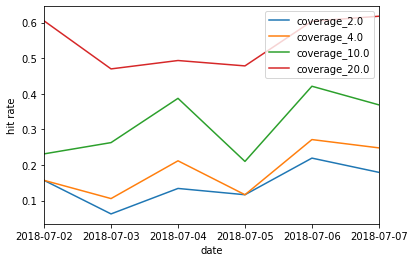

In [11]:
# gca stands for 'get current axis'
ax = plt.gca()

df_by_date.plot(kind='line',x='date',y='coverage_2.0',ax=ax)
df_by_date.plot(kind='line',x='date',y='coverage_4.0', ax=ax)
df_by_date.plot(kind='line',x='date',y='coverage_10.0', ax=ax)
df_by_date.plot(kind='line',x='date',y='coverage_20.0', ax=ax)
ax.set_ylabel('hit rate')

plt.show()

## Coverage vs hit rates

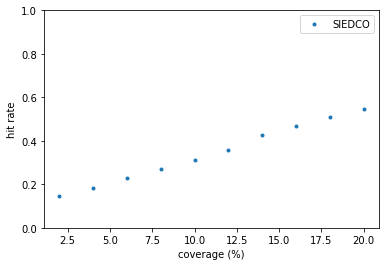

In [12]:
ax = plt.gca()
plt.plot(coverages,df_siedco.mean(),'.',label='SIEDCO')
legend = ax.legend(loc='best')
ax.set_ylabel('hit rate')
ax.set_xlabel('coverage (%)')
plt.ylim(0, 1)
plt.show()

In [14]:
from services.process_data import ProcessData
path ='/Users/anamaria/Desktop/dev/security_project/aggressive_behavior_model/pkl/'
file_name = 'coverage_vs_hitrate_city_KDE'
ProcessData.save_element(path,file_name,df_siedco)